In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kde
from scipy.optimize import minimize
import tqdm
from IPython.display import display, Math
import corner
import emcee

np.random.seed(12345)

plt.rcParams['figure.dpi'] = 200

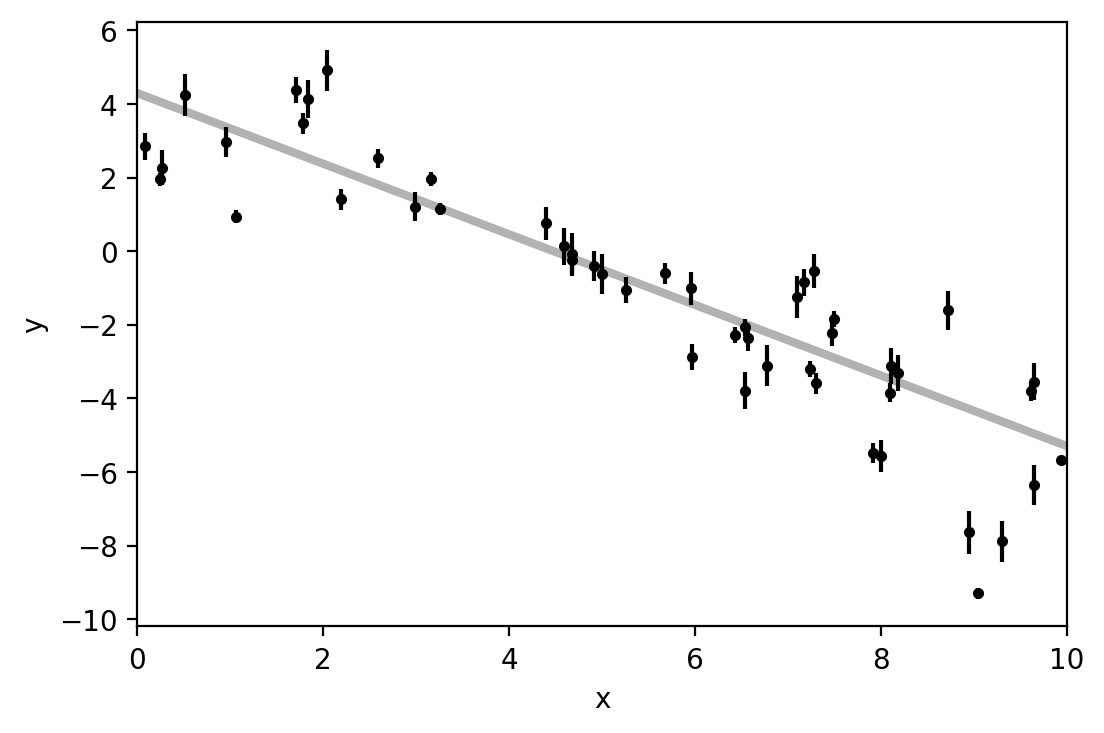

In [4]:
# test linear regression

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y)* np.random.randn(N)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Simplest Affine Invariant Ensemble Sampler

In [5]:
# model definition: linear
def modelFunction(X, w):
    m, b, log_f = w
    
    #reshape params
    new_m    = m.reshape(-1,1)
    new_b    = b.reshape(-1,1)
    
    return new_m * X + new_b

In [6]:
# likelyhood function
def logLikelihood(w, X, Y, Yerr):
    
    log_f = w[-1]
    #reshape params
    new_logf = log_f.reshape(-1,1)
    
    model = modelFunction(X, w)
    sigma2 = Yerr ** 2 + model ** 2 * np.exp(2 * new_logf)
    return -0.5 * np.sum((Y - model) ** 2 / sigma2 + np.log(sigma2))

In [7]:
# Prior distribution: only give a limitation range here
def logPrior(w,wRange):
    #m, b, log_f = w
    for i in range(w.shape[0]):
        for j in range(w.shape[1]):
            if (w[i,j] < wRange[i,0]) or (w[i,j] > wRange[i,1]):
                return -np.inf
        return 0.0

In [8]:
# Prob = Prior * Likelihood
def log_probability(w, X, Y, Yerr):
    lp = logPrior(w,wRange)
    if not np.isfinite(lp):
        return -np.inf
    return lp + logLikelihood(w, X, Y, Yerr)

In [9]:
# give initial values of parameters
def samplePrior():
    """
    get initial values of the parameters for each walker
    
    :param nwalker: integer, number of walkers

    
    This function returns:
    
    w:  2d Array with the initial values; (nParams, nwalker)
    
    """
    
    nParams = wRange.shape[0] # the number of parameters
    w = np.zeros((nParams, nwalker))
    for i in range(nParams):
        w[i] = (wRange[i,1]-wRange[i,0])* np.random.rand(nwalker) + wRange[i,0] # randomly choose a value in the acceptable range
    
    return w 

In [11]:
# determine the length of the step
def sampleStretch(a=2):
    """
    Draws one random scaling variable z per parameter 
    from the probability density g(z)
    
    
    :param nParams: number of parameters
    :param a: integer, defines the interval g(z) as [1/a, a], default = 2
    
    
    
    This function returns:
    
    zz:  1d array with the scaling valiable for one move per walker; (nParams)
    
    """
    
    zo       = 1./a
    zf       = a
    
    Integral = 2.*(np.sqrt(zf) - np.sqrt(zo)) #integral of stretch distrib. funct over the interval [1/a, a]
    norm     = 1./Integral
    
    #draws a random number from a uniform pdf
    uniform  = np.random.rand()
    
    #draws a random scaling variable z, from the inverse cumulative distribution
    #function and a uniform random number
    zz       = ( uniform/(2*norm) + np.sqrt(zo) )**2
    
    return zz


In [12]:
#improve this function to all walkers at the same time
def propose(w, k, wRange, Nwalker, a):
        """
        Propose a new position for one walker given the position of
        another.

        :param w:
            2D Array of parameters per walker (nParams, nwalker)
            
        :param k:
            walker index
            
         :param Nwalker:
            Integrer, number of walkers
            
        :param a:
            strech model hyperparameter
        
        
        This function returns:

        * q: The new proposed positions for the walkers in ``ensemble``.

        * newlnprob: The vector of log-probabilities at the positions
          given by 'q'.

        * accept: An array of `booleans` informing whether or not
          the proposed position for each walker was accepted.

        """
        
        nParams = wRange.shape[0]

        wNew    = np.zeros_like(w, dtype=np.float64)
        wNew[:] = w #(nParams, nwalker)

        zz = sampleStretch(a) #scaling variable


        # Generate the vectors of random numbers that will produce the
        # proposal.
        rint         = np.random.randint(Nwalker-1)
        complEnsem   = np.zeros((nParams,Nwalker-1), dtype=np.float64)
        complEnsem[:]= np.delete(w, k,1) #list of complementary walkers of p0

        
        # Calculate the proposed positions and the log-probability there.
        wNew[:,k]    = complEnsem[:,rint] + zz * (w[:,k] - complEnsem[:,rint])
        logpNew = logPrior(wNew,wRange) ## ?? shouldnt this be log posterior

        return wNew, logpNew, zz

In [13]:
# main function for MCMC
def MCMC(Nwalker, Nsteps, data, wrange, a):
    
    x, y, yerr = data
    #reshape data
    new_x    = np.tile(x, (nwalker,1)) 
    new_y    = np.tile(y, (nwalker,1))
    new_yerr = np.tile(yerr, (nwalker,1))
    

    # start off at some random w drawn from our prior distribution
    w = samplePrior()
    logp, logl = log_probability(w, new_x, new_y, new_yerr), logLikelihood(w,new_x, new_y, new_yerr) #two floats

    nParam = w.shape[0] # the value of w plus its likelihood
    chain = np.zeros((Nwalker, Nsteps, nParam + 1)) #(nwalker,Nsteps, nParam +1)

    
    # count the number of successful proposals
    ngood = 0
    for i in tqdm.tqdm_notebook(range(Nsteps)):
        
        
        for k in tqdm.tqdm_notebook(range(Nwalker)):
            
            wNew, logpNew, zz = propose(w, k, wrange, Nwalker, a)

            # Only evaluate the likelihood if prior prob isn't zero
            loglNew = -np.Inf
            if logpNew != -np.Inf:
                loglNew = logLikelihood(wNew, new_x, new_y, new_yerr)

            # Log of acceptance ratio for all parameters
            logRatio = (nParam - 1.) * np.log(zz) + logpNew - logp

            logRatio = min(0.0, logRatio) #float

            # Acceptance/rejection
            #accept = [alpha <= np.exp(logRatio)[i] for i in range(nParam)]
            if np.random.rand() <= np.exp(logRatio):
                w[:,k] = wNew[:,k]
                logp = logpNew
                logl = loglNew

            #sumgood = np.sum(np.ones(nParam)*accept) #count how many parameters were updated
            
            ngood += 1

            chain[k, i, :-1] = w[:,k]
            chain[k, i, -1] = logl
            
    s = chain.shape #walker, param
    np.savetxt("chain.txt", chain.reshape(s[0] * s[1], s[2]), delimiter=',')
    return chain.reshape(s[0] * s[1], s[2]), ngood/(Nsteps*nwalker) #flattened chain, Acceptance ratio

In [14]:
import time

In [15]:
%%time
# the number of steps
N = 100
data = [x,y,yerr]
nwalker = 6
A = 2.
# Ranges in parameter values:
wRange = np.array([[-5.,0.5], [0., 10.], [-10., 1.]])

# run MCMC
chain, goodFrac = MCMC(Nwalker = nwalker, Nsteps = N, data = data, wrange = wRange, a = A)

print(f"\n\nAcceptance ratio: {goodFrac}")

<ipython-input-13-05c0fea5b84f>:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(Nsteps)):


  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-13-05c0fea5b84f>:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm.tqdm_notebook(range(Nwalker)):


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

<ipython-input-6-83fdb9dd5f86>:9: RuntimeWarning: overflow encountered in exp
  sigma2 = Yerr ** 2 + model ** 2 * np.exp(2 * new_logf)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]



Acceptance ratio: 1.0
CPU times: user 1.34 s, sys: 90.4 ms, total: 1.43 s
Wall time: 1.43 s


In [21]:
chain[burn:end,0]

array([], dtype=float64)

In [29]:
samples = chain.shape[0]

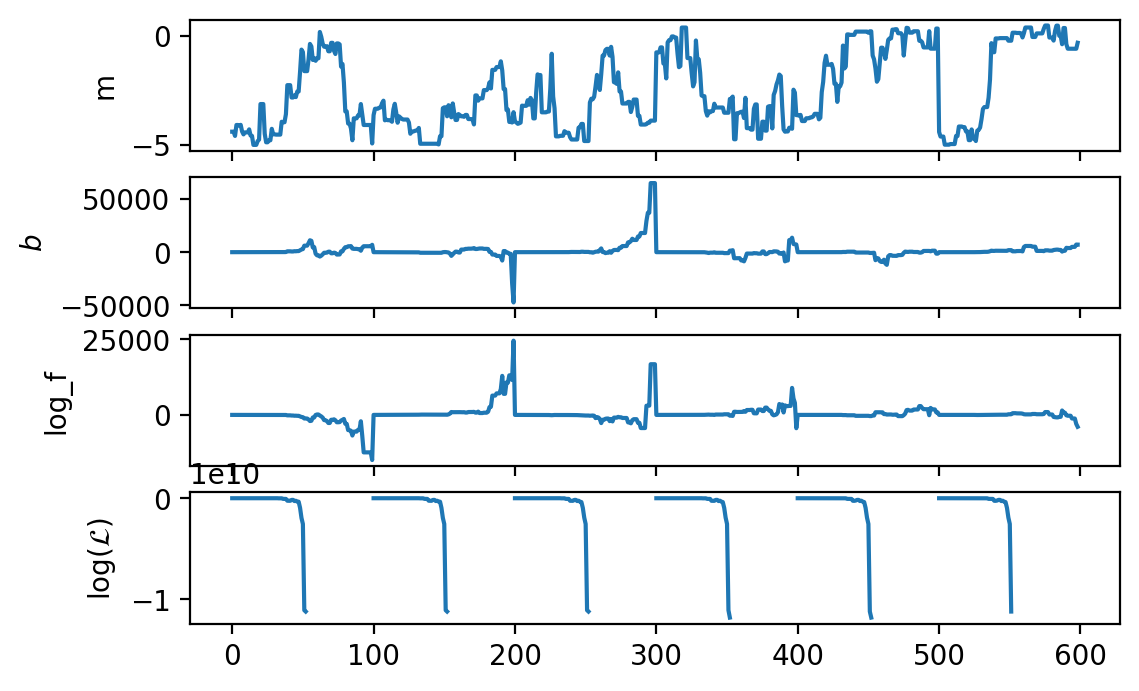

In [22]:
# Have a look on the MC chains 
walker=1
burn=0
end = -1

m  = chain[burn:end,0]
b = chain[burn:end,1]
log_f = chain[burn:end,2]
ll = chain[burn:end,3]

fig, ax = plt.subplots(4, 1, sharex=True)
ax[0].plot(m)
ax[0].set_ylabel(r'm')

ax[1].plot(b)
ax[1].set_ylabel(r'$b$')

ax[2].plot(log_f)
ax[2].set_ylabel(r'log_f')


ax[3].plot(ll)
ax[3].set_ylabel(r'$\log(\mathcal{L})$');#ax.plot(h,m)
#ax.set_ylabel(r'm')



In [35]:
# Have a look on the MC chains 
walker=1
burn=5000
end = -1

m  = chain[burn:end,0]
b = chain[burn:end,1]
log_f = chain[burn:end,2]
ll = chain[burn:end,3]


fig, ax = plt.subplots(4, 1, sharex=True)
ax[0].plot(m)
ax[0].set_ylabel(r'm')

ax[1].plot(b)
ax[1].set_ylabel(r'$b$')

ax[2].plot(log_f)
ax[2].set_ylabel(r'log_f')


ax[3].plot(ll)
ax[3].set_ylabel(r'$\log(\mathcal{L})$');

#samples = chain[burn:,:]

/Users/gabriela/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:2563: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin


IndexError: index 0 is out of bounds for axis 0 with size 0

In [83]:
# autocorrelated function -> determine every N steps to pick one step
def autocorrelate(x,lags):
    n=len(x)
    # pad 0s to 2n-1
    size=2*n-1
    
    xp=x-np.mean(x)
    var=np.var(x)

    # do fft and ifft
    cf=np.fft.fft(xp, size)
    sf=cf.conjugate()*cf
    corr=np.fft.ifft(sf).real
    corr=corr/var/n

    return corr[:len(lags)]


def auto(chain, nlag, labs):
    nParam = chain.shape[1]-1
    lags = np.arange(nlag)
    fig, ax = plt.subplots()
    for i in range(nParam):
        result = autocorrelate(chain[:,i],lags)
        ax.plot(result, label=labs[i])
        
    ax.legend()
    ax.set_xlabel('lag k [steps]')
    ax.set_ylabel('P(k)')
    plt.tight_layout();

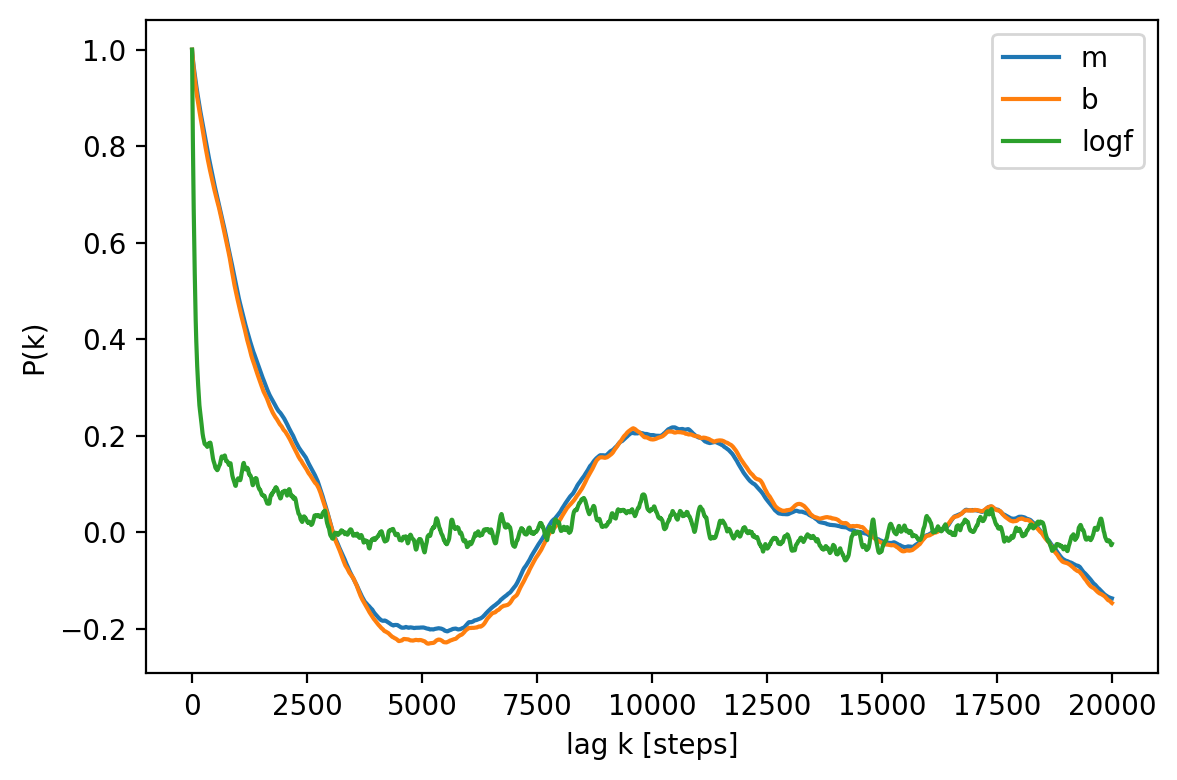

In [84]:
labs = ['m','b','logf']
auto(chain[0,burn:end,:], nlag=20000, labs=labs)

In [132]:
#combine all of chains of walkers
#burn is the first N steps which will be discarded
#thin is every how many steps choose one step to avoid co-corelated between adjacent steps
def flat_chain(chain,burn=100, thin=1500):
    walker = len(chain)
    Nsteps = len(chain[0])
    NParams = len(chain[0][0])
    print(walker,Nsteps,NParams)
    use_chain_point_all = []
    for i in range(walker):
        use_walker_chain = chain[i,burn:,:]
        use_len = len(use_walker_chain)
        index = 0
        while index < use_len:
            use_chain_point_all.append(use_walker_chain[index,:])
            index+=1500
    
    return np.array(use_chain_point_all)
        
        

In [89]:
final_chain = flat_chain(chain,burn=burn, thin=1000)
samples = final_chain

32 100000 4


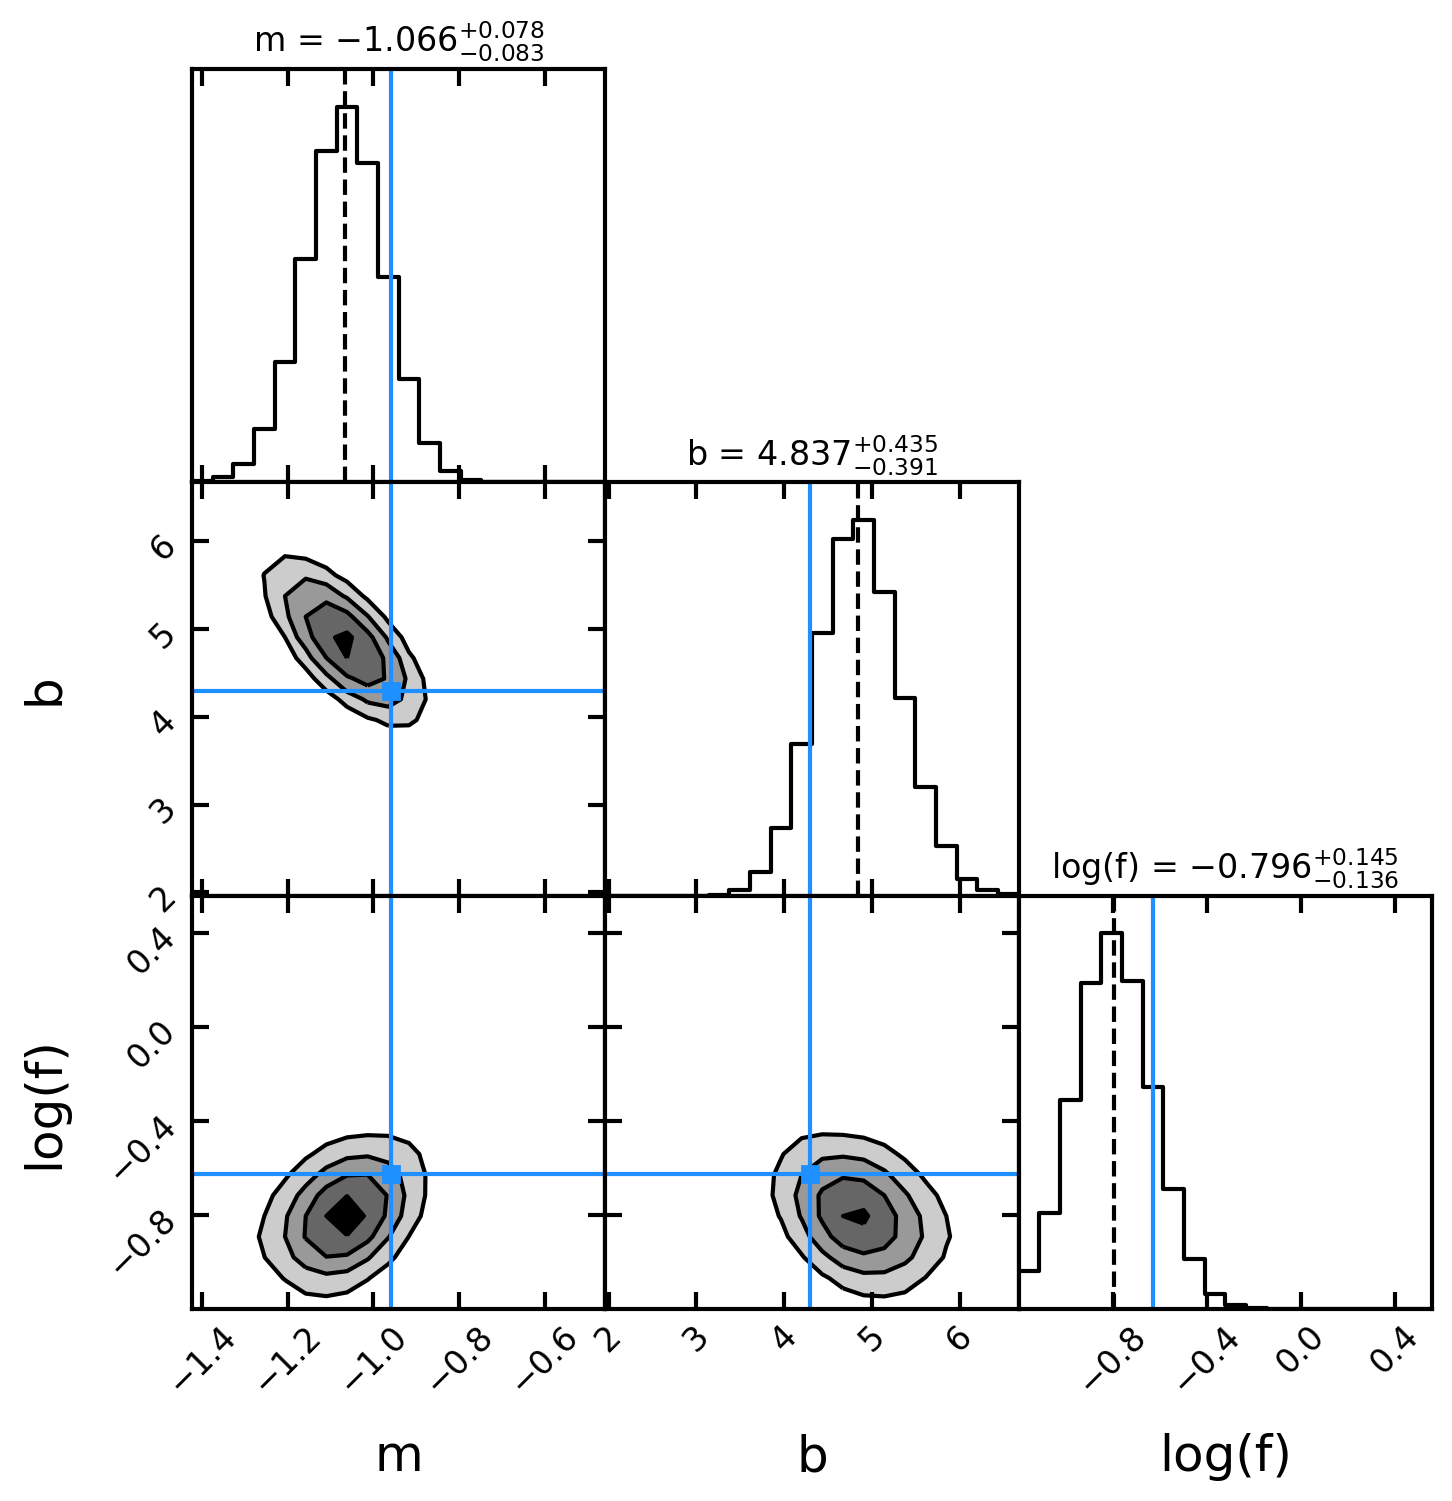

In [90]:
# show corner
labels = ["m", "b", "log(f)"]

fig = corner.corner(\
    samples[:,:-1],\
    truths=[m_true, b_true, np.log(f_true)],\
    truth_color='dodgerblue',\
    labels=labels,\
    label_kwargs={'color':'k', 'fontsize': 18},\
    show_titles=True,\
    title_fmt = '.3f',\
    title_kwargs={'color':'k', 'fontsize': 12},\
    plot_datapoints=False,\
    plot_density=False,\
    plot_contours=True,\
    fill_contours=True,\
    smooth1d=True,\
    smooth=True,\
    reverse=False,\
    quantiles=[0.5])

for axs in fig.get_axes():
        axs.tick_params(axis='both', which='major', direction='in', bottom=True, top=True, left=True, right=True, length=6, width=1.5, labelsize=12)
        axs.tick_params(axis='both', which='minor', direction='in', bottom=True, top=True, left=True, right=True, length=3, width=1.5, labelsize=12)
        for axis in ['top','bottom','left','right']:
            axs.spines[axis].set_linewidth(1.5)
plt.subplots_adjust(hspace=0.0, wspace=0.0)


Text(0, 0.5, 'y')

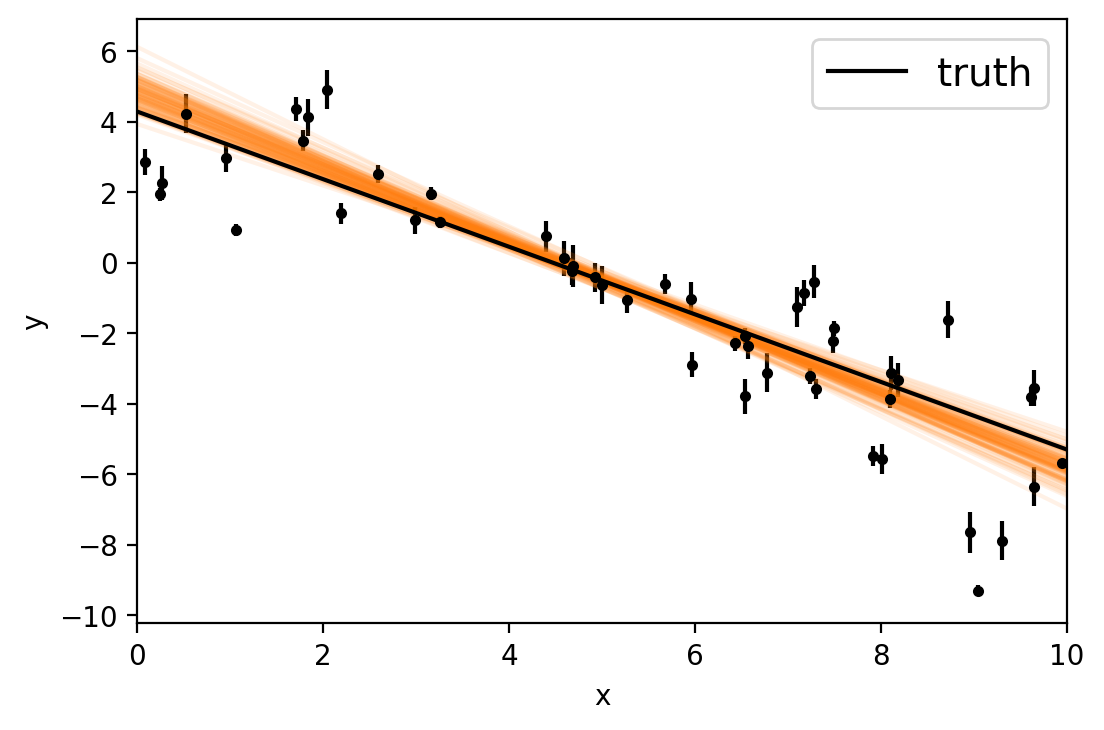

In [91]:
inds = np.random.randint(len(samples), size=100)
for ind in inds:
    sample = samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")

In [92]:
for i in range(3):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>